In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import time
import datetime
import wandb
import gc
import pandas as pd
import numpy as np
from train_helper import train_fn, valid_fn
from config import TrainConfig
from utils import get_logger, get_optimizer_params, get_scheduler, load_pretrained_state_dict
from dltime.data.ts_datasets import UCR_UEADataset
from dltime.data.tsc_dataset_names import *
from dltime.models.GTN import GTN, GTN_time_wise, GTN_channel_wise
from transformers import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CFG = TrainConfig()

In [26]:
dataset_name = "HandMovementDirection"
test_dataset = UCR_UEADataset(dataset_name, split="test", extract_path=CFG.extract_path)

feat_dim = test_dataset[0]['input'].shape[-1]
max_len = test_dataset.max_len
num_classes = len(test_dataset.y2label)

test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
test_labels = test_dataset.y

In [29]:
model = GTN(
    d_model=512, 
    d_input=max_len,
    d_channel=feat_dim,
    d_output=num_classes,
    d_hidden=1024,
    q=8,
    v=8,
    h=8,
    N=8,
    dropout=0.2,
    device=CFG.device,
    pe=True,
    mask=False).to(CFG.device)

# model.load_state_dict(torch.load('./outputs/JapaneseVowels_GTN_best_retrain.pth'))
model.load_state_dict(torch.load('./outputs/HandMovementDirection_GTN_best_retrain.pth'))

<All keys matched successfully>

In [30]:
total_preds = []
total_encoding_inp = []
total_score_inp = []
total_encoding_ch = []
total_score_ch = []
for step, item in enumerate(test_loader):
    for k, v in item.items():
        item[k] = v.to(CFG.device)

    labels = item['label']
    batch_size = labels.size(0)
    with torch.no_grad():
        outputs = model(item['input'], 'train')
        y_preds, encoding_input, score_input, encoding_channel, score_channel = outputs[0], outputs[4], outputs[2], \
            outputs[5], outputs[3]

    # loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
    
    total_preds.append(torch.argmax(y_preds, dim=-1).cpu())
    total_encoding_inp.append(encoding_input.detach().cpu())
    total_score_inp.append(score_input.detach().cpu())
    total_encoding_ch.append(encoding_channel.detach().cpu())
    total_score_ch.append(score_channel.detach().cpu())

total_preds = torch.cat(total_preds, dim=0)
total_encoding_inp = torch.cat(total_encoding_inp, dim=0)
total_score_inp = torch.cat(total_score_inp, dim=0)
total_encoding_ch = torch.cat(total_encoding_ch, dim=0)
total_score_ch = torch.cat(total_score_ch, dim=0)

In [31]:
total_score_inp.size()

torch.Size([592, 400, 400])

In [32]:
def plot_time(signal, sample_rate=1, title=None):
    """matplot画图
    """
    time = np.arange(0, len(signal)) * (1.0 / sample_rate)
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    if title:
        plt.title(title)
    plt.grid()

In [33]:
test_dataset[0]['input'].size()

torch.Size([400, 10])

In [34]:
total_score_inp[0].size()

torch.Size([400, 400])

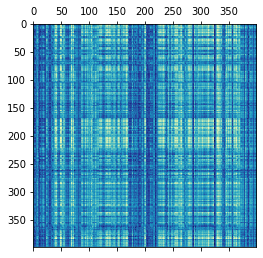

In [35]:
plt.matshow(total_score_inp[0], cmap=plt.cm.YlGnBu)


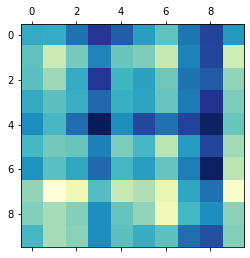

In [36]:
plt.matshow(total_score_ch[0], cmap=plt.cm.YlGnBu)

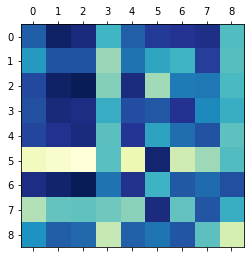

In [13]:
plt.matshow(total_score_ch[9], cmap=plt.cm.YlGnBu)

In [38]:
def soft_max(x):
    z = np.array(x) - np.max(x)
    t = np.exp(z)
    a = np.exp(z) / np.sum(t)
    return a

def min_max(x):
    z = np.array(x) - np.min(x)
    return z / (np.max(x) - np.min(x))

def plot_mul_dim_series(series, plot=True, dims=None, save=False, save_name='test'):
    x = np.arange(len(series[:, 1]))
    plt.figure(figsize=[20, 10])
    if dims is not None:
        for dim in dims:
            s = series[:, dim]
            print(s.size())
            plt.plot(x, s, label=f'dim {dim}')
    else:
        for i, s in enumerate(series):
            plt.plot(x, s, label=f"dim {i}", )
    
    plt.legend()
    if save:
        plt.savefig(f"./outputs/analyse_pic/{save_name}.jpg")
    if plot:
        plt.show()


torch.Size([400])
torch.Size([400])


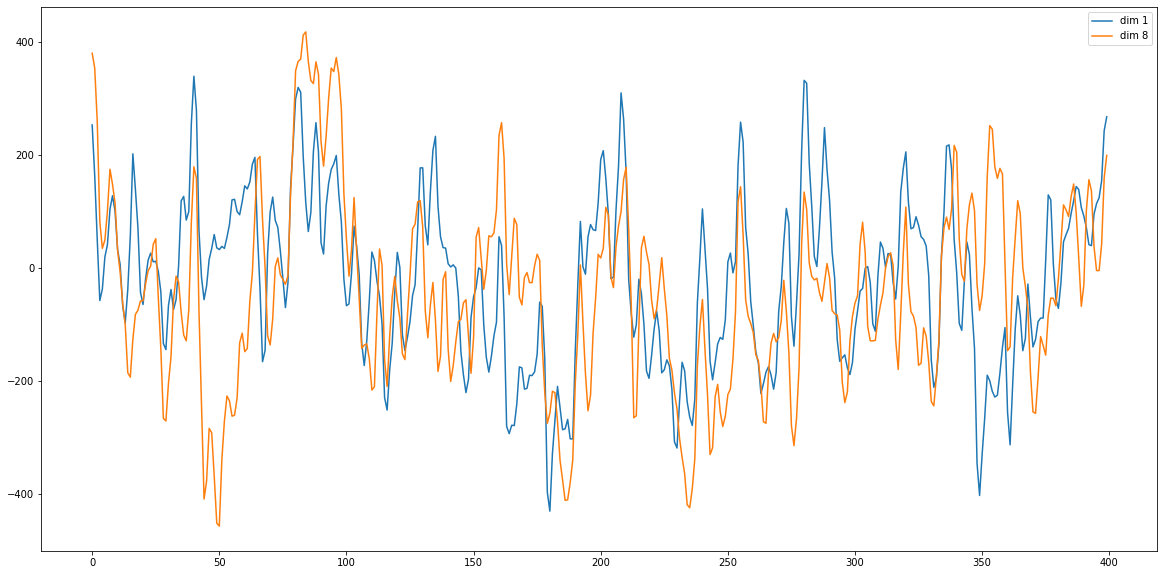

In [39]:
plot_mul_dim_series(test_dataset[9]['input'], dims=[1, 8])

In [40]:
from sklearn.manifold import TSNE

In [41]:
tsne2d = TSNE(n_components=2, init='pca', random_state=2022)

In [42]:
total_encoding_ch.size()

torch.Size([74, 10, 512])

In [44]:
ch_encoding_2d = tsne2d.fit_transform(total_encoding_ch.view(74, -1))

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


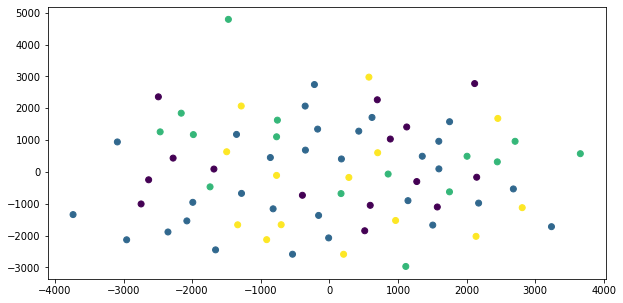

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(ch_encoding_2d[:, 0], ch_encoding_2d[:, 1], c=test_labels,label="t-SNE")

In [53]:
encoding_inp = total_encoding_inp[0]
encoding_inp.size()

torch.Size([400, 512])

In [54]:
ch_encoding_2d = tsne2d.fit_transform(encoding_inp)

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


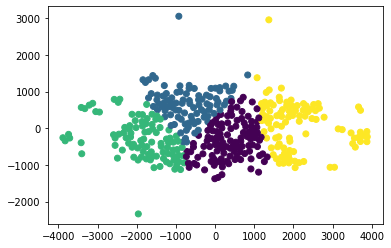

[1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 2 2 1 1 3 1 0 2 2 1 1 1 1 1 1 0 2 2
 2 0 3 3 0 2 2 2 2 1 0 3 3 0 2 2 2 0 0 0 1 2 2 2 2 1 1 2 2 2 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 1 0 3 3 3 0 0 0 0 3 3 3 3 3 0 1 1 1 3 3 0 0 0 2 2 2
 0 0 2 0 0 0 0 3 3 3 3 3 0 1 1 1 1 3 3 3 0 0 3 3 3 3 3 3 3 0 0 0 0 3 0 0 0
 2 0 0 3 3 3 0 0 1 1 0 0 3 3 3 0 0 0 3 3 3 3 2 2 2 2 2 1 0 0 2 2 2 2 2 0 1
 1 1 1 1 1 1 0 1 1 1 2 2 1 1 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 2 2 1
 1 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 1 1 0 0 0 2 2 1 0 0 3 0 0 0 0 0 0 3 3 3 0
 0 2 2 2 0 0 0 2 2 2 2 1 0 0 2 2 2 2 0 0 3 3 3 3 0 1 1 1 1 3 3 0 0 0 0 0 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 2 1 1 0 0 0 0 0 0 0 3 3 3 3 0 1 1 1 0 0 3 0 0 0 2 0 0 0 0 2
 2 2 2 2 2 1 1 1 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[[  366.17307  -343.57516]
 [ -674.4923    666.52216]
 [-1874.813    -308.51385]
 [ 2111.8965     76.54421]]
294185152.0
0.3428603


In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


k_means = KMeans(n_clusters=4, random_state=2022)

k_means.fit(ch_encoding_2d)

y_predict = k_means.predict(ch_encoding_2d)
plt.scatter(ch_encoding_2d[:,0],ch_encoding_2d[:,1],c=y_predict)
plt.show()
print(k_means.predict((ch_encoding_2d)))
# print(metrics.calinski_harabaz_score(ch_encoding_2d,y_predict))
print(k_means.cluster_centers_)
print(k_means.inertia_)
print(metrics.silhouette_score(ch_encoding_2d,y_predict))
